In [6]:
import pip
pip.main(["install", "openpyxl"])
import copy
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


# Discription of data from Article
* **Area**: It gave the number of pixels within the borders of a pumpkin seed
* **Perimeter**: It gave the circumference in pixels of a pumpkin seed
* **Major Axis Length**: It gave the circumference in pixels of a pumpkin seed
* **Minor Axis Length**: It gave the small axis distance of a pumpkin seed
* **Eccentricity**: It gave the eccentricity of a pumpkin seed
* **Convex Area**: It gave the number of pixels of the smallest convex shell at the region formed by the pumpkin seed
* **Extent**: It returned the ratio of a pumpkin seed area to the bounding box pixels
* **Equiv Diameter**: It was formed by multiplying the area of the pumpkin seed by four and dividing by the number pi, and taking the square root
* **Compactness**: It proportioned the area of the pumpkin seed relative to the area of the circle with the same circumference
* **Solidity**: It considered the convex and convex condition of the pumpkin seeds
* **Roundness**: It measured the ovality of pumpkin seeds without considering its distortion of the edges
* **Aspect Ratio**: It gave the aspect ratio of the pumpkin seeds

# Read, transform and split data

In [7]:
pumpkin = pd.read_excel("D:/Games/seeds/Pumpkin_Seeds_Dataset.xlsx")
pumpkin.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207,Çerçevelik
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487,Çerçevelik
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929,Çerçevelik
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624,Çerçevelik
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557,Çerçevelik


In [8]:
pumpkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               2500 non-null   int64  
 1   Perimeter          2500 non-null   float64
 2   Major_Axis_Length  2500 non-null   float64
 3   Minor_Axis_Length  2500 non-null   float64
 4   Convex_Area        2500 non-null   int64  
 5   Equiv_Diameter     2500 non-null   float64
 6   Eccentricity       2500 non-null   float64
 7   Solidity           2500 non-null   float64
 8   Extent             2500 non-null   float64
 9   Roundness          2500 non-null   float64
 10  Aspect_Ration      2500 non-null   float64
 11  Compactness        2500 non-null   float64
 12  Class              2500 non-null   object 
dtypes: float64(10), int64(2), object(1)
memory usage: 254.0+ KB


All data without missing values. 

In [9]:
pumpkin['Class'].unique()

array(['Çerçevelik', 'Ürgüp Sivrisi'], dtype=object)

In [10]:
pumpkin['target'] = np.nan
pumpkin.loc[pumpkin['Class'] == 'Çerçevelik', 'target'] = 0
pumpkin.loc[pumpkin['Class'] == 'Ürgüp Sivrisi', 'target'] = 1
len(pumpkin)

2500

In [11]:
pumpkin['target'].mean()

0.48

In [12]:
x_train, x_test, y_train, y_test = train_test_split(pumpkin, pumpkin['target'], test_size = 0.2, random_state = 42, stratify = pumpkin['target'])

In [13]:
features =  list(x_train.columns)[:-2]

Let's see features distribution and find outliers (only extreme ones with more then 3 IQR)

Area


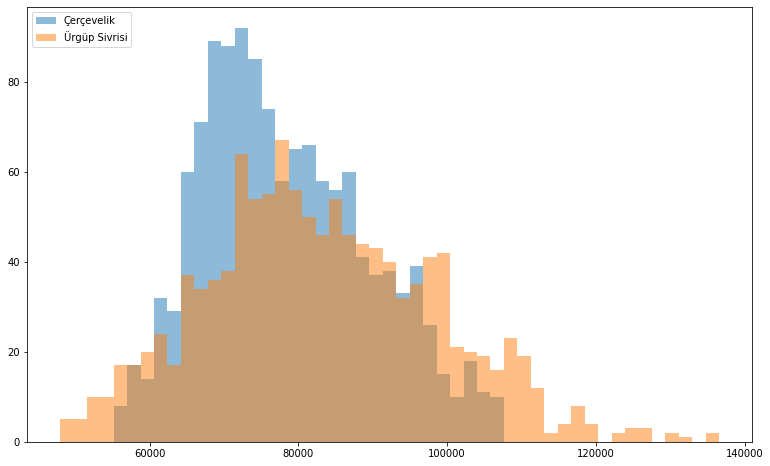

Perimeter


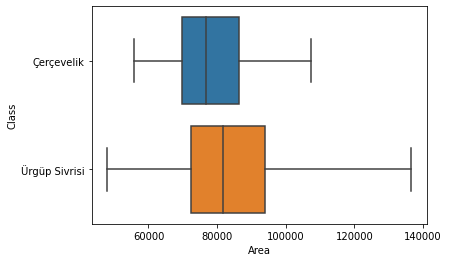

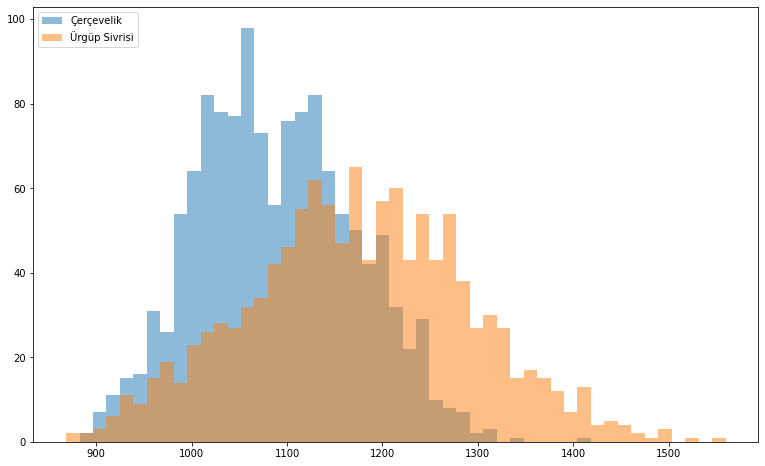

Major_Axis_Length


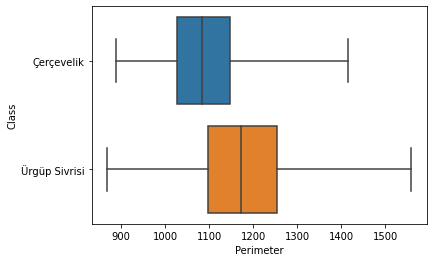

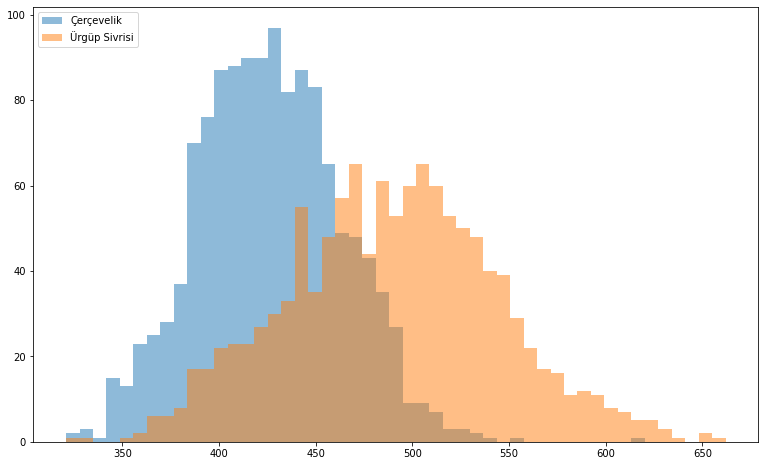

Minor_Axis_Length


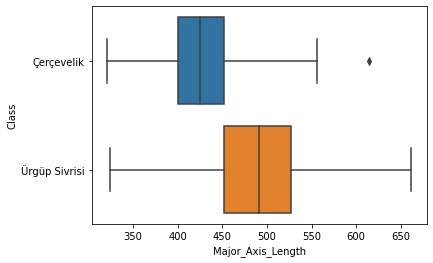

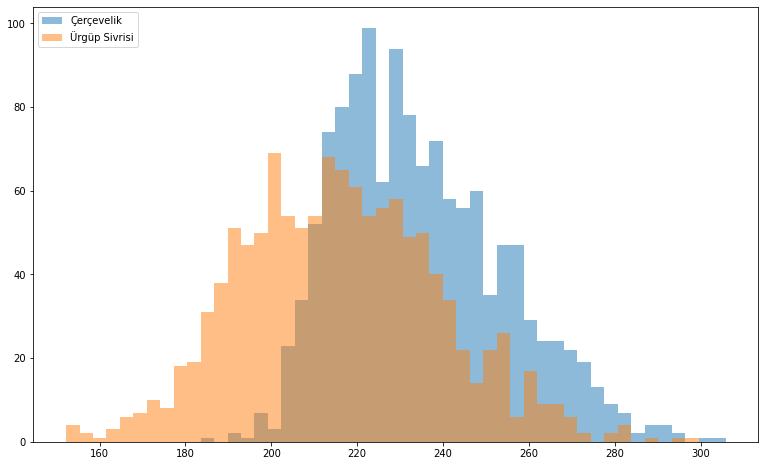

Convex_Area


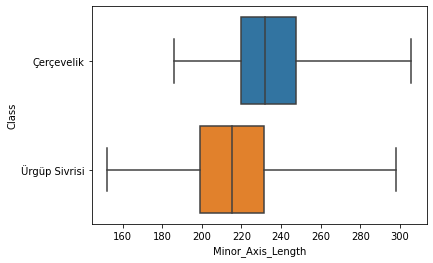

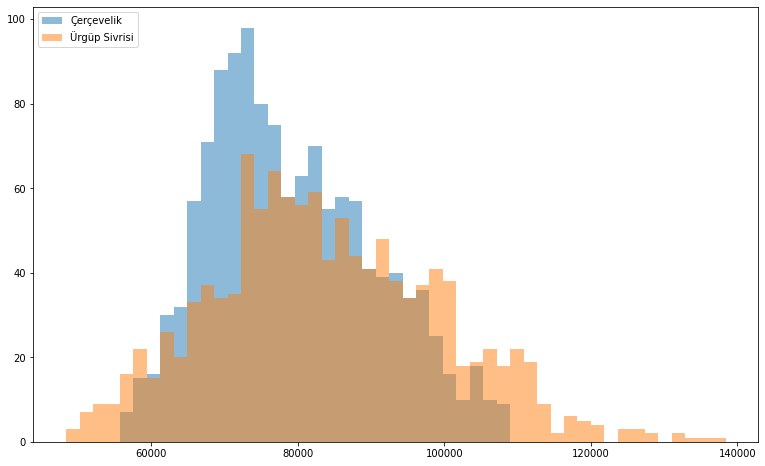

Equiv_Diameter


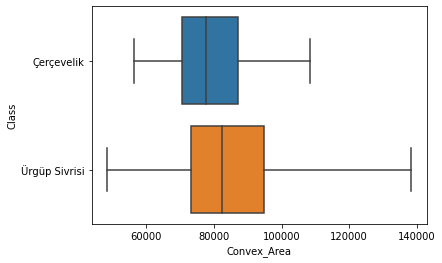

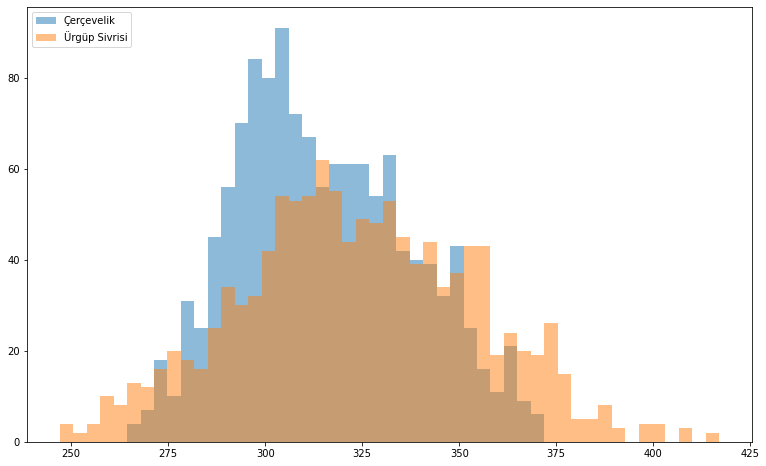

Eccentricity


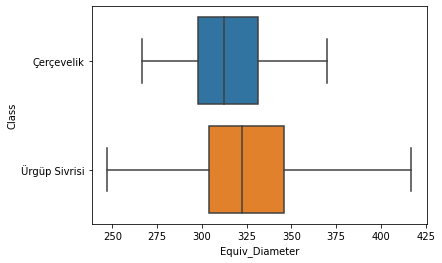

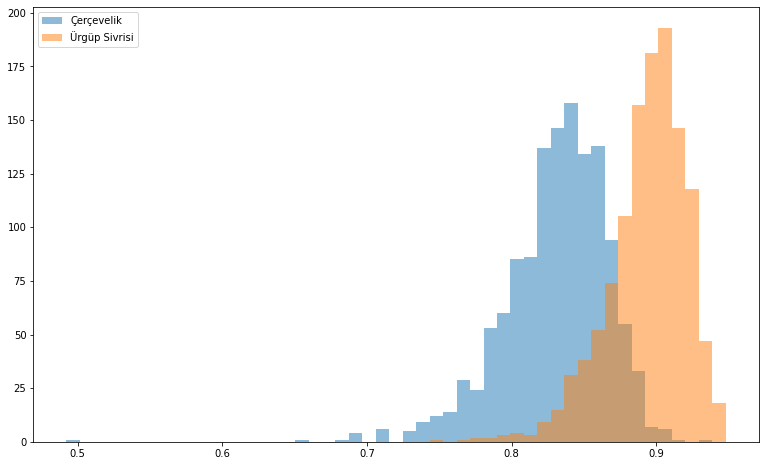

Solidity


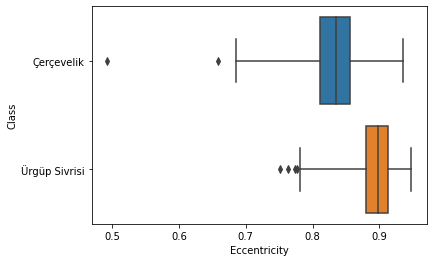

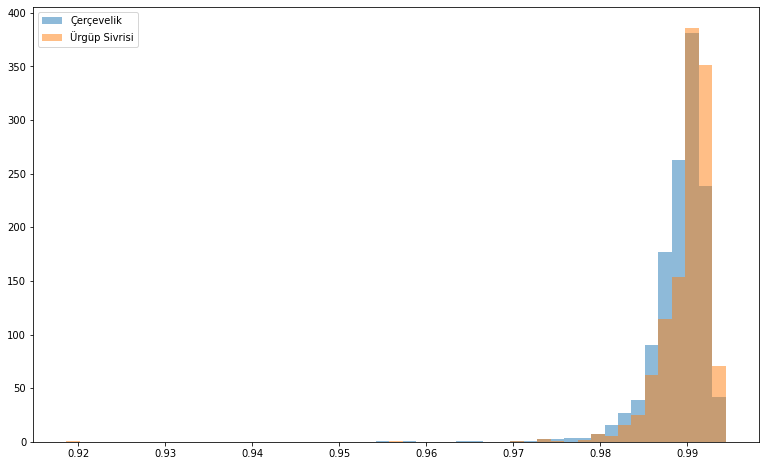

Extent


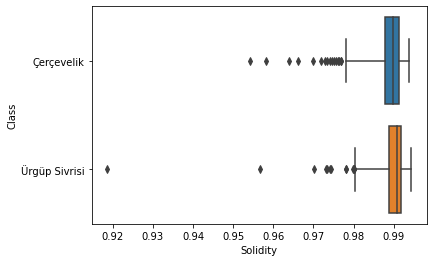

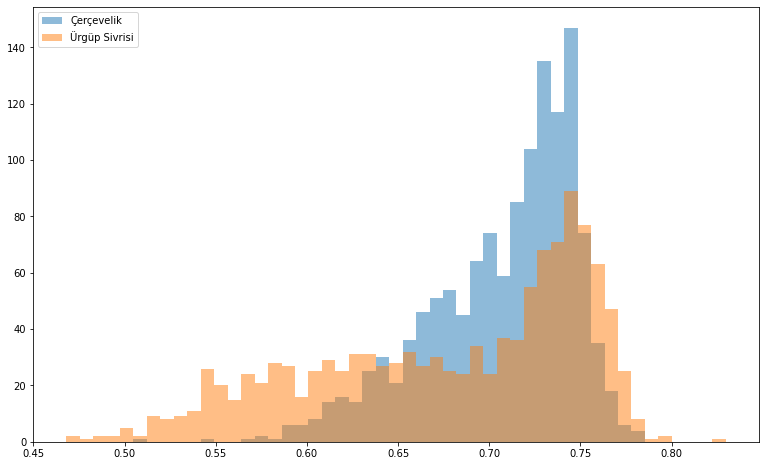

Roundness


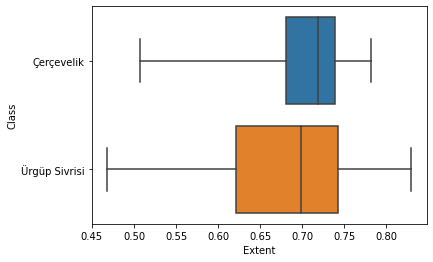

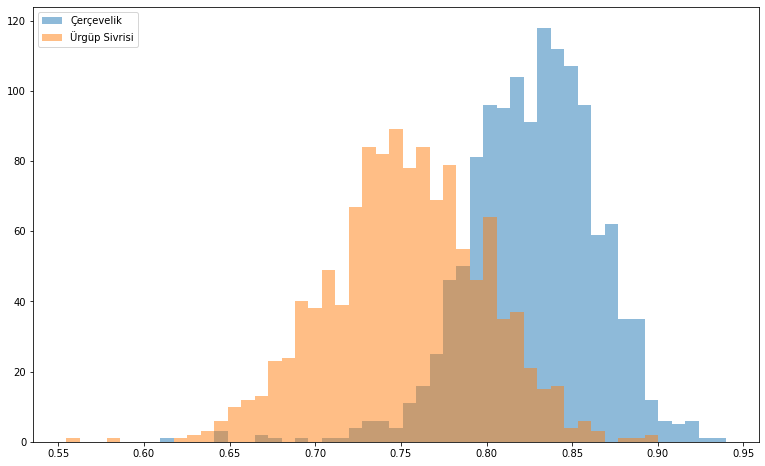

Aspect_Ration


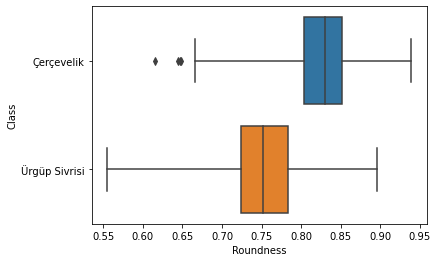

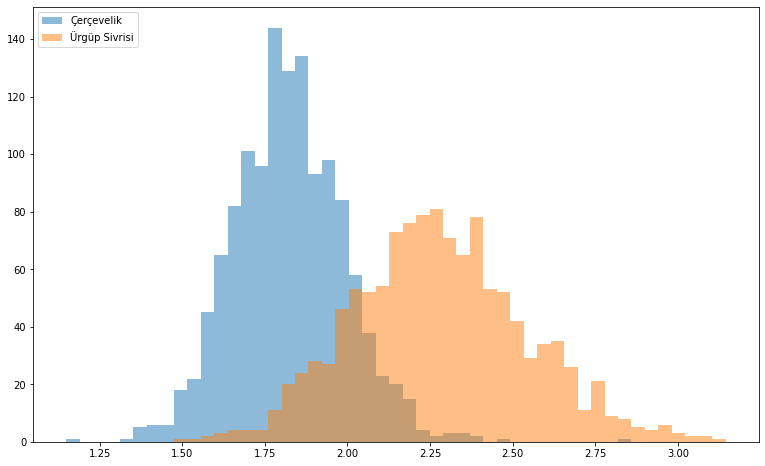

Compactness


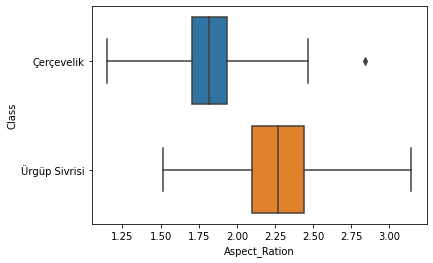

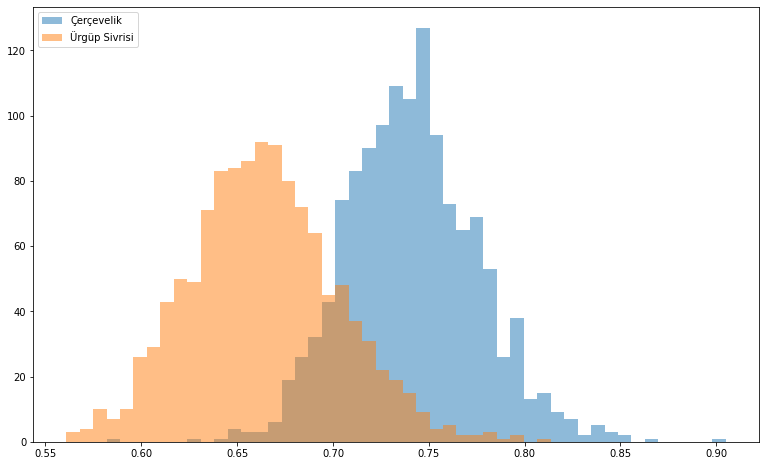

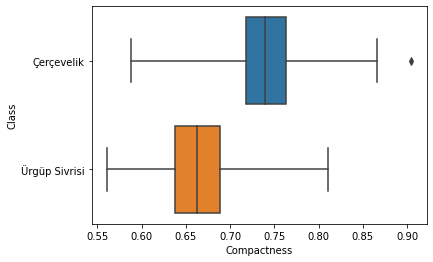

In [14]:
for col in features:
    print(col)
    plt.figure(figsize=(13,8))
    a = pumpkin[col][pumpkin['Class'] == 'Çerçevelik']
    b = pumpkin[col][pumpkin['Class'] == 'Ürgüp Sivrisi']

    bins = np.linspace(pumpkin[col].min(),pumpkin[col].max(), 50)

    plt.hist(a, bins, alpha = 0.5, label='Çerçevelik')
    plt.hist(b, bins, alpha = 0.5, label='Ürgüp Sivrisi')
    plt.legend(loc='upper left')

    plt.show()
    sns.boxplot(x=pumpkin[col], y = pumpkin['Class'], whis = 3)
   

# Baseline

In [15]:
clf = LogisticRegression(random_state = 12)
clf.fit(x_train[features], x_train['target'])

LogisticRegression(random_state=12)

In [16]:
y_pred = clf.predict(x_test[features])
proba = clf.predict_proba(x_test[features])[:, 1]
y_pred_t = clf.predict(x_train[features])
proba_t = clf.predict_proba(x_train[features])[:, 1]
print('Train: accuracy_score = ', accuracy_score(y_pred_t, y_train), 'roc_auc_score = ',roc_auc_score(y_train, proba_t))
print('Test: accuracy_score = ', accuracy_score(y_pred, y_test), 'roc_auc_score = ',roc_auc_score(y_test, proba))

Train: accuracy_score =  0.879 roc_auc_score =  0.938467548076923
Test: accuracy_score =  0.852 roc_auc_score =  0.9292307692307693


# Define some useful functions

In [17]:
def bins_generation(df, feature, bins_num = 10):
    df = df[[feature, 'target']]
    
    df[f'bin_{feature}'], bins = pd.qcut(df[feature], bins_num, duplicates = 'drop', retbins = True) 
    bins[0] = -np.inf
    bins[-1] = np.inf
    df[f'bin_{feature}'] = pd.cut(df[feature], bins)
    df[f'bin_{feature}'] = df[f'bin_{feature}'].apply(lambda x: x.left)
    df[f'bin_{feature}'] = df[f'bin_{feature}'].astype(float)
            
    return df, bins

In [18]:
def check_bins_generation(df, feature, bins_num = 5):
    for i in range(bins_num, 1, -1):
        df_binned, bins = bins_generation(df, feature, i)
        xg = pd.DataFrame(df_binned.groupby(f'bin_{feature}') \
                                  .agg({feature: 'count',
                                        'target': 'sum'})) \
                                  .reset_index()
        if xg[feature].min() > len(df) * 0.2 and not (xg[feature] == xg['target']).any():      
            break
        
    return df_binned, bins

In [19]:
def woe_calc(df, feature, target):
    df = pd.concat([df[feature], target], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'count', 'tr']
    df['n_good'] = df['tr'] * df['count']
    df['n_bad'] = (1 - df['tr']) * df['count']
    df['good_rate'] = df['n_good'] / df['n_good'].sum()
    df['bad_rate'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['good_rate'] / df['bad_rate'])
    
    return df

In [20]:
def del_extreme_outlier(pumpkin):
    cols = pumpkin.columns
    cols = cols.drop(['Class', 'Eccentricity', 'Solidity', 'target'])
    pumpkin_C = pumpkin[pumpkin['Class'] == 'Çerçevelik']
    pumpkin_U = pumpkin[pumpkin['Class'] == 'Ürgüp Sivrisi']
    for col in cols: # only large outliers over 3 IQR
        Q1, Q3 = np.percentile(pumpkin_C[col], [25,75])
        IQR = Q3-Q1
        top_C = Q3 + 3*IQR
        bottom_C = Q1 - 3*IQR
        Q1, Q3 = np.percentile(pumpkin_U[col], [25,75])
        IQR = Q3-Q1
        top_U = Q3 + 3*IQR
        bottom_U = Q1 - 3*IQR
        pumpkin = pumpkin[((pumpkin['Class'] == 'Çerçevelik') & (pumpkin[col] > bottom_C) & (pumpkin[col] < top_C)) |
                         ((pumpkin['Class'] == 'Ürgüp Sivrisi') & (pumpkin[col] > bottom_U) & (pumpkin[col] < top_U))]
        pumpkin = pumpkin[pumpkin['Eccentricity'] > 0.7]
        pumpkin = pumpkin[pumpkin['Solidity'] > 0.97]
    return pumpkin

In [21]:
def plot_by_woe(woe):
    x = np.array(woe.iloc[:, 0].apply(str))
    y = woe['WoE']
    plt.figure(figsize = (15, 10))
    plt.plot(x, y, marker = 'o', color = 'violet', markersize = 20,  markerfacecolor = 'gray')
    plt.xlabel(woe.columns[0])
    plt.ylabel('WoE')
    plt.title(str('WoE of ' + woe.columns[0]))
    plt.xticks(rotation = 45) 
    plt.show()

In [22]:
def forward():
    ginis = {}

    for feat in list(set(woe_feat_names) - set(forward_feature_list)):
        logreg = LogisticRegression(random_state = 0)
        scores = cross_val_score(logreg, x_train[forward_feature_list + [feat]].astype(float), x_train['target'], scoring = 'roc_auc', cv = 3)
        ginis[feat] = scores.mean() 

    new_feat = max(ginis, key = ginis.get)
    gini_list.append(max(ginis.values()))
    if (gini_list[-1] - gini_list[-2]) < 0.0005:
        print('END')
    else:
        forward_feature_list.append(new_feat)
    print('Add new feature: ', new_feat)
    print('roc_auc_score: ', gini_list[-1])
    print('-------------------------------')

In [23]:
def recalc_forward():
    logreg = LogisticRegression(random_state = 0)
    scores = cross_val_score(logreg, x_train[forward_feature_list], x_train['target'], scoring = 'roc_auc', cv = 3)
    gini_list.append(scores.mean())
    print('roc_auc_score: ', gini_list[-1])
    print('-------------------------------')

In [24]:
def aWoE_num(df, feat):
    df[feat] = pd.cut(df[feat[:-4]], bins[feat])
    df[feat] = df[feat].apply(lambda x: x.left).astype(float)
    df[feat + '_woe'] = df[feat].apply(lambda x: woe[woe[feat] == x]['WoE'].values[0])
    return df

In [25]:
def add_WoE_num(x_test,feat):
    x_test = aWoE_num(x_test, feat)
    print(x_test[['target', feat]].groupby(feat).agg(['count', 'mean']))

In [26]:
def cWoE_num(df, feat):
    df[feat + '_woe'] = df[feat].apply(lambda x: woe[woe[feat] == x]['WoE'].values[0])
    return df

In [27]:
def change_WoE_num(x_test, x_train, feat):
    x_train = cWoE_num(x_train, feat)
    x_test = cWoE_num(x_test, feat)
    print(x_test[['target', feat]].groupby(feat).agg(['count', 'mean']))

In [28]:
def merge_bins(train, test, feature, from_, to_):
    train.loc[train[train[feature].isin(from_)].index, feature] = to_
    test.loc[test[test[feature].isin(from_)].index, feature] = to_
    return train, test

# Features pretreatment

The main idea is using WoE insted of features values. To do this we need to split values into bins (each bin should be more than 10% of all data) and replace values in each bin by WoE of this bin.

In [29]:
x_train = del_extreme_outlier(x_train)
y_train = x_train['target']

In [30]:
bin_feat_names = []
bins = {}

for feat in tqdm(features):
    a, bin_ = check_bins_generation(x_train, feat, 5)
    x_train[f'{feat}_bin'] = a[f'bin_{feat}']
    bin_feat_names.append(f'{feat}_bin')
    bins[f'{feat}_bin'] = bin_

100%|██████████| 12/12 [00:00<00:00, 67.80it/s]


In [31]:
woe_feat_names = []

for feat in tqdm(bin_feat_names):
    woe = woe_calc(x_train, feat, x_train['target'])
    x_train[f'{feat}_woe'] = x_train[feat].apply(lambda x: woe[woe[feat] == x]['WoE'].values[0])
    woe_feat_names.append(f'{feat}_woe')

100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


# Advanced baseline

The main idea is using WoE of features bins instead of features values.

In [32]:
x1_test = copy.deepcopy(x_test)
for feat in features:
    feat = feat  + '_bin'
    woe = woe_calc(x_train, feat, x_train['target'])
    add_WoE_num(x1_test,feat)

          target          
           count      mean
Area_bin                  
-inf         123  0.414634
 70798.00    120  0.441667
 78999.50    124  0.403226
 89401.25    133  0.646617
              target          
               count      mean
Perimeter_bin                 
-inf             118  0.245763
 1048.180        123  0.382114
 1123.190        134  0.447761
 1203.487        125  0.832000
                      target          
                       count      mean
Major_Axis_Length_bin                 
-inf                     115  0.191304
 414.515                 126  0.238095
 449.178                 129  0.488372
 492.446                 130  0.961538
                      target          
                       count      mean
Minor_Axis_Length_bin                 
-inf                     122  0.803279
 211.193                 121  0.421488
 224.514                 129  0.395349
 240.449                 128  0.312500
                target          
               

In [33]:
clf = LogisticRegression(random_state = 12)
clf.fit(x_train[woe_feat_names], x_train['target'])

LogisticRegression(random_state=12)

In [34]:
y_pred_t = clf.predict(x_train[woe_feat_names])
proba_t = clf.predict_proba(x_train[woe_feat_names])[:, 1]
y_pred = clf.predict(x1_test[woe_feat_names])
proba = clf.predict_proba(x1_test[woe_feat_names])[:, 1]
print('Train: accuracy_score = ', accuracy_score(y_pred_t, y_train), 'roc_auc_score = ',roc_auc_score(y_train, proba_t))
print('Test: accuracy_score = ', accuracy_score(y_pred, y_test), 'roc_auc_score = ',roc_auc_score(y_test, proba))

Train: accuracy_score =  0.8809045226130653 roc_auc_score =  0.9431255056634305
Test: accuracy_score =  0.862 roc_auc_score =  0.9373076923076924


* Baseline model:
Train roc_auc_score = 0.938,
Test roc_auc_score = 0.929
* Advanced baseline model:
Train roc_auc_score = 0.943,
Test roc_auc_score = 0.937

As can be seen from the previous data, the quality of the model increases. The next step is using forward selection to find the most useful features and bins merging to reduce overfitting.

# Forward selection

In [35]:
forward_feature_list = []
gini_list = [0]
forward()

Add new feature:  Compactness_bin_woe
roc_auc_score:  0.9154774176074083
-------------------------------


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


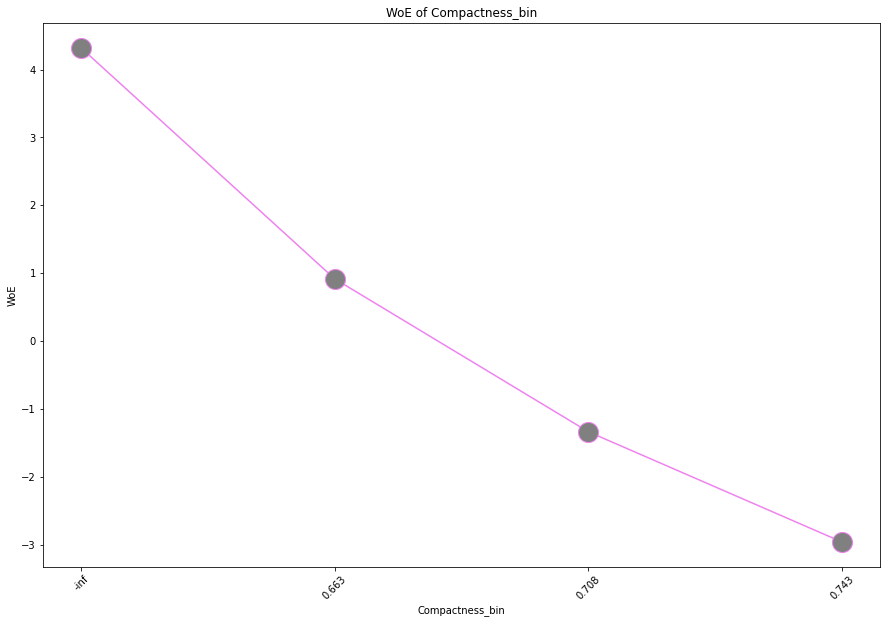

In [36]:
woe = woe_calc(x_train, 'Compactness_bin', x_train['target'])
plot_by_woe(woe)

In [37]:
add_WoE_num(x_test,'Compactness_bin')

                target          
                 count      mean
Compactness_bin                 
-inf               126  0.976190
 0.663             123  0.674797
 0.708             125  0.224000
 0.743             126  0.047619


In [38]:
forward()

Add new feature:  Solidity_bin_woe
roc_auc_score:  0.9323908259317015
-------------------------------


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


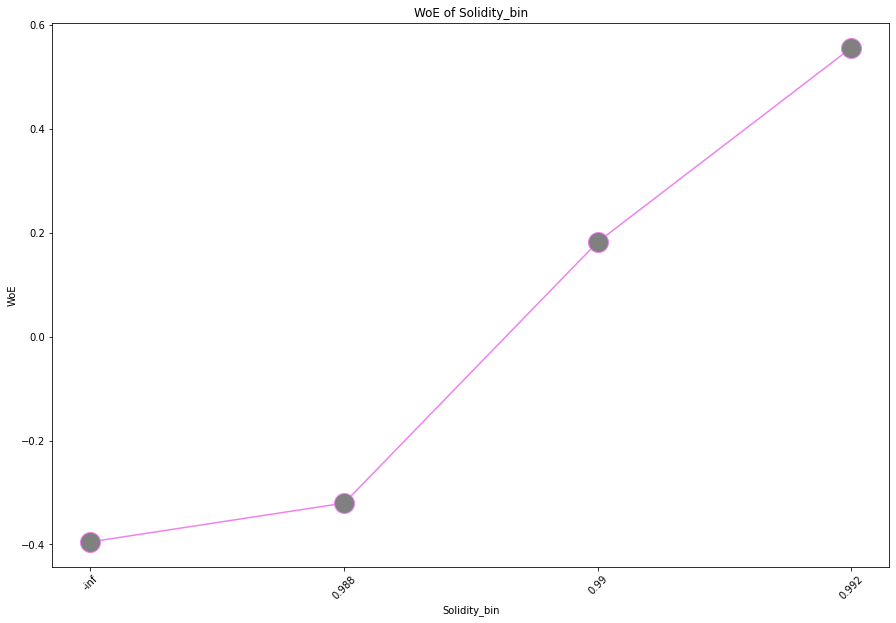

In [39]:
woe = woe_calc(x_train, 'Solidity_bin', x_train['target'])
plot_by_woe(woe)

In [40]:
add_WoE_num(x_test,'Solidity_bin')

             target          
              count      mean
Solidity_bin                 
-inf            129  0.418605
 0.988          126  0.388889
 0.990          123  0.536585
 0.992          122  0.581967


In [41]:
x_train, x_test = merge_bins(x_train, x_test, 'Solidity_bin', [0.988], -np.inf)

In [42]:
change_WoE_num(x_test, x_train, 'Solidity_bin')

             target          
              count      mean
Solidity_bin                 
-inf            255  0.403922
 0.990          123  0.536585
 0.992          122  0.581967


In [43]:
recalc_forward()
forward()

roc_auc_score:  0.9322696180320135
-------------------------------
Add new feature:  Roundness_bin_woe
roc_auc_score:  0.9353120206242796
-------------------------------


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


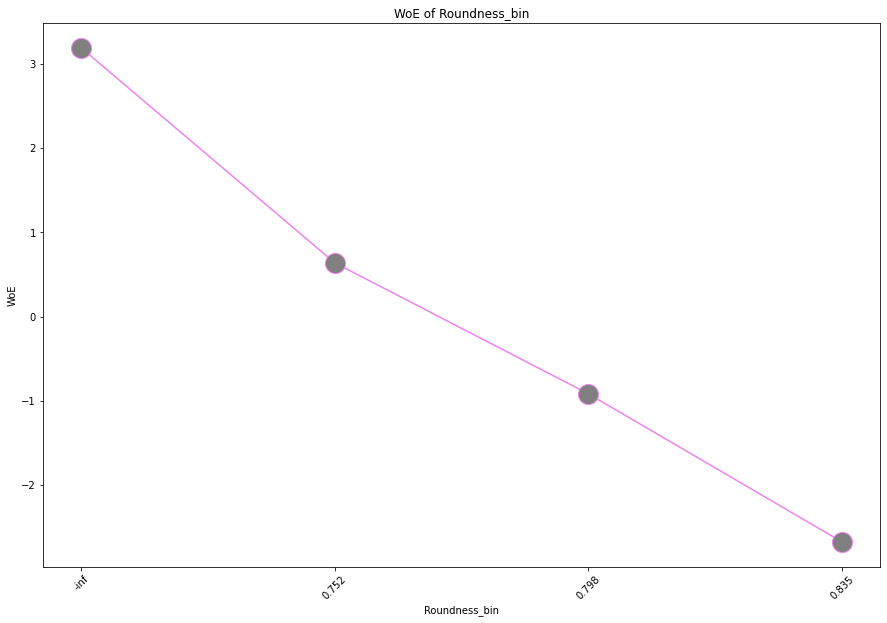

In [44]:
woe = woe_calc(x_train, 'Roundness_bin', x_train['target'])
plot_by_woe(woe)

In [45]:
add_WoE_num(x_test,'Roundness_bin')

              target          
               count      mean
Roundness_bin                 
-inf             125  0.960000
 0.752           119  0.638655
 0.798           138  0.268116
 0.835           118  0.059322


In [46]:
forward()

Add new feature:  Extent_bin_woe
roc_auc_score:  0.9365280458632789
-------------------------------


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


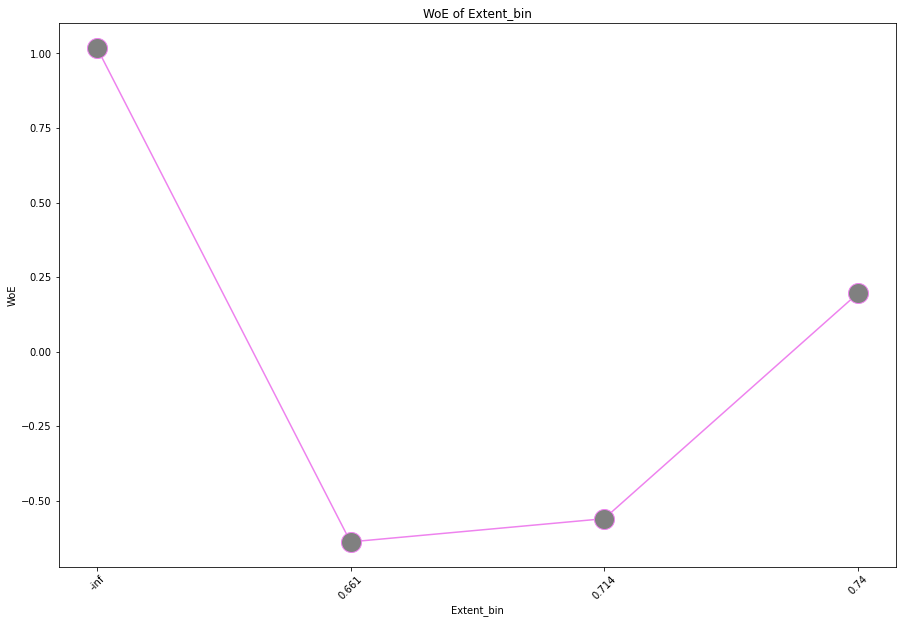

In [47]:
woe = woe_calc(x_train, 'Extent_bin', x_train['target'])
plot_by_woe(woe)

In [48]:
add_WoE_num(x_test,'Extent_bin')

           target          
            count      mean
Extent_bin                 
-inf          147  0.680272
 0.661        117  0.350427
 0.714        124  0.362903
 0.740        112  0.482143


In [49]:
x_train, x_test = merge_bins(x_train, x_test, 'Extent_bin', [0.661], 0.714)

In [50]:
change_WoE_num(x_test, x_train, 'Extent_bin')

           target          
            count      mean
Extent_bin                 
-inf          147  0.680272
 0.714        241  0.356846
 0.740        112  0.482143


In [51]:
recalc_forward()
forward()

roc_auc_score:  0.9360577412027933
-------------------------------
Add new feature:  Major_Axis_Length_bin_woe
roc_auc_score:  0.936832987970936
-------------------------------


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


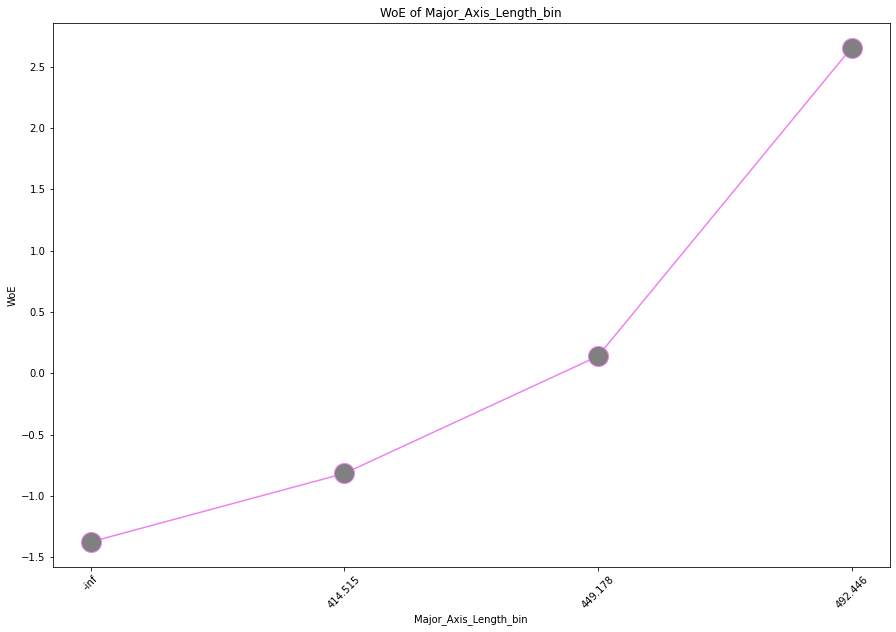

In [52]:
woe = woe_calc(x_train, 'Major_Axis_Length_bin', x_train['target'])
plot_by_woe(woe)

In [53]:
add_WoE_num(x_test,'Major_Axis_Length_bin')

                      target          
                       count      mean
Major_Axis_Length_bin                 
-inf                     115  0.191304
 414.515                 126  0.238095
 449.178                 129  0.488372
 492.446                 130  0.961538


In [54]:
forward()

Add new feature:  Minor_Axis_Length_bin_woe
roc_auc_score:  0.9417430357213483
-------------------------------


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


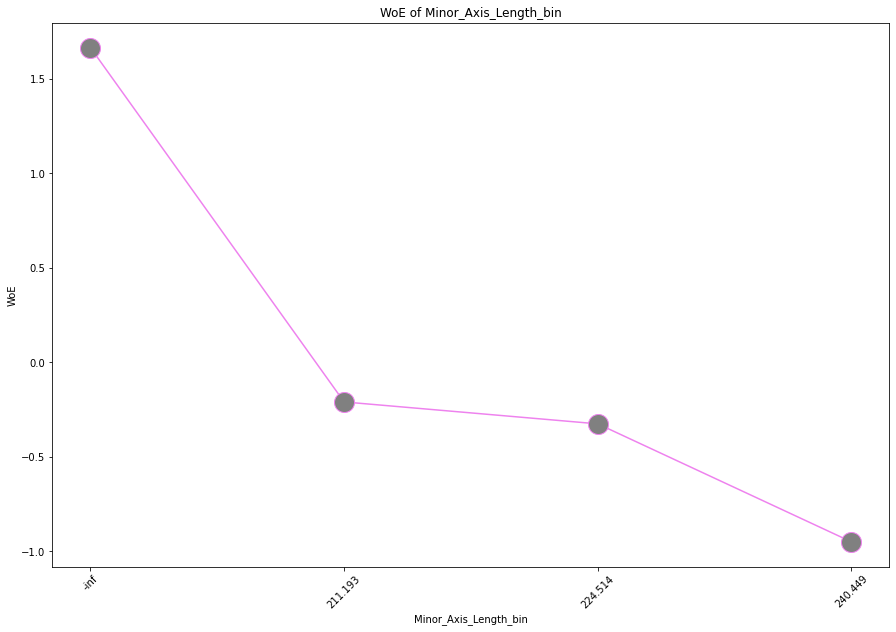

In [55]:
woe = woe_calc(x_train, 'Minor_Axis_Length_bin', x_train['target'])
plot_by_woe(woe)

In [56]:
add_WoE_num(x_test,'Minor_Axis_Length_bin')

                      target          
                       count      mean
Minor_Axis_Length_bin                 
-inf                     122  0.803279
 211.193                 121  0.421488
 224.514                 129  0.395349
 240.449                 128  0.312500


In [57]:
x_train, x_test = merge_bins(x_train, x_test, 'Minor_Axis_Length_bin', [211.173], 224.514)

In [58]:
change_WoE_num(x_test, x_train, 'Minor_Axis_Length_bin')

                      target          
                       count      mean
Minor_Axis_Length_bin                 
-inf                     122  0.803279
 211.193                 121  0.421488
 224.514                 129  0.395349
 240.449                 128  0.312500


In [59]:
recalc_forward()
forward()

roc_auc_score:  0.9417430357213483
-------------------------------
END
Add new feature:  Equiv_Diameter_bin_woe
roc_auc_score:  0.9417051491485298
-------------------------------


In [60]:
clf = LogisticRegression(random_state = 12)
clf.fit(x_train[forward_feature_list], x_train['target'])
y_pred_test = clf.predict(x_test[forward_feature_list])
proba_test = clf.predict_proba(x_test[forward_feature_list])[:, 1]
y_pred_train = clf.predict(x_train[forward_feature_list])
proba_train = clf.predict_proba(x_train[forward_feature_list])[:, 1]
print('Train: accuracy_score = ', accuracy_score(y_pred_train, x_train['target']), 'roc_auc_score = ',roc_auc_score(x_train['target'], proba_train))
print('Test: accuracy_score = ', accuracy_score(y_pred_test, x_test['target']), 'roc_auc_score = ',roc_auc_score(x_test['target'], proba_test))

Train: accuracy_score =  0.8804020100502512 roc_auc_score =  0.9431229773462784
Test: accuracy_score =  0.86 roc_auc_score =  0.9378124999999999


* Advanced baseline model:
Train roc_auc_score = 0.943,
Test roc_auc_score = 0.937
* Model after feature selection:
Train roc_auc_score = 0.943,
Test roc_auc_score = 0.938

Roc_auc_score of train data stay the same, but roc_auc_score of test data increases, it means that overfitting is decreased. We use only 6 features instead of 12 in advanced baseline model.